Exploring DSC SET Data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [25]:
# load sets into dataframe
dsc_sets = pd.read_csv('datasets/dsc_sets.csv')
# merge duplicate columns
dsc_sets["Enrolled Resp Rate"] = dsc_sets["Enrolled/ Resp Rate"].fillna(dsc_sets["Enrolled/  Resp Rate"])
dsc_sets = dsc_sets.drop(columns=["Enrolled/ Resp Rate", "Enrolled/  Resp Rate"])
# remove Letter from Avg Grade Received
dsc_sets["Avg Grade Received"] = (
    dsc_sets["Avg Grade Received"]
    .str.extract(r'(\d+\.\d+|\d+)')   # extract first number
    .astype(float)
)
dsc_sets.columns = dsc_sets.columns.str.replace('*', '', regex=False)
dsc_sets.head()

,Instructor,Course,Term,Avg Grade Received,Avg Hours Worked,Learning Average,Structure Average,Environment Average,course_title,Enrolled Resp Rate
0,"Bellur, Umesh",DSC 180B - Data Science Project II (A00),WI25,3.93,9.93,3.74,3.55,4.12,dsc180b,114 (14.04%)
1,"Bellur, Umesh",DSC 180B - Data Science Project II (B00),WI25,3.99,11.89,4.02,3.74,3.80,dsc180b,118 (16.95%)
2,"Rampure, Suraj",DSC 180B - Data Science Project II (A00),WI24,3.96,9.60,4.60,4.59,4.58,dsc180b,97 (10.31%)
3,"Rampure, Suraj",DSC 180B - Data Science Project II (B00),WI24,3.99,6.23,4.57,4.57,4.53,dsc180b,138 (9.42%)
4,"Weng, Tsui-Wei (lily)",DSC 140B - Representation Learning (A00),SP25,3.71,7.38,4.19,4.13,4.24,dsc140b,124 (45.16%)


In [30]:
# Add division and elective labels
dsc_sets['course_num'] = dsc_sets['course_title'].str.extract(r'(\d+)').astype(int)
# add division column
dsc_sets["division"] = dsc_sets["course_num"].apply(lambda x: "Lower" if x < 100 else "Upper")
dsc_sets = dsc_sets.drop(columns=["course_num"])
# add elective column
required_courses = ["dsc10", "dsc20", "dsc30", "dsc40a", "dsc40b", "dsc80", 
                    "dsc100", "dsc102", "dsc106", "dsc140a", "dsc140b", "dsc148", "dsc180a", "dsc180b"]
dsc_sets["is_elective"] = dsc_sets["course_title"].apply(
    lambda x: "Required" if x in required_courses else "Elective"
)
dsc_sets.columns = dsc_sets.columns.str.replace('*', '', regex=False)
dsc_sets.columns = dsc_sets.columns.str.replace(' ', '_')
dsc_sets.head()


,Instructor,Course,Term,Avg_Grade_Received,Avg_Hours_Worked,Learning_Average,Structure_Average,Environment_Average,course_title,Enrolled_Resp_Rate,division,is_elective
0,"Bellur, Umesh",DSC 180B - Data Science Project II (A00),WI25,3.93,9.93,3.74,3.55,4.12,dsc180b,114 (14.04%),Upper,Required
1,"Bellur, Umesh",DSC 180B - Data Science Project II (B00),WI25,3.99,11.89,4.02,3.74,3.80,dsc180b,118 (16.95%),Upper,Required
2,"Rampure, Suraj",DSC 180B - Data Science Project II (A00),WI24,3.96,9.60,4.60,4.59,4.58,dsc180b,97 (10.31%),Upper,Required
3,"Rampure, Suraj",DSC 180B - Data Science Project II (B00),WI24,3.99,6.23,4.57,4.57,4.53,dsc180b,138 (9.42%),Upper,Required
4,"Weng, Tsui-Wei (lily)",DSC 140B - Representation Learning (A00),SP25,3.71,7.38,4.19,4.13,4.24,dsc140b,124 (45.16%),Upper,Required


In [27]:
electives = dsc_sets[dsc_sets["is_elective"] == "Elective"]
required = dsc_sets[dsc_sets["is_elective"] == "Required"]
electives.head()

,Instructor,Course,Term,Avg Grade Received,Avg Hours Worked,Learning Average,Structure Average,Environment Average,course_title,Enrolled Resp Rate,division,is_elective
16,"Mishne, Gal",DSC 120 - Signal Processing/Data Analys (A00),FA23,3.08,9.44,4.64,4.34,4.29,dsc120,29 (31.03%),Upper,Elective
17,"Roberts, Margaret Earling",DSC 161 - Text as Data (A00),SP25,3.73,4.60,4.60,4.60,4.60,dsc161,32 (15.63%),Upper,Elective
18,"Roberts, Margaret Earling",DSC 161 - Text as Data (A00),WI24,3.50,6.50,4.75,4.75,4.75,dsc161,14 (28.57%),Upper,Elective
63,"Tiefenbruck, Janine LoBue",DSC 95 - Tutor Appshp in Data Science (A00),SP25,NaN,1.50,5.00,5.00,5.00,dsc95,22 (18.18%),Lower,Elective
64,"Langlois, Marina",DSC 95 - Tutor Appshp in Data Science (A00),WI25,NaN,1.67,5.00,5.00,5.00,dsc95,24 (16.67%),Lower,Elective


<Axes: xlabel='division', ylabel='Avg Grade Received'>

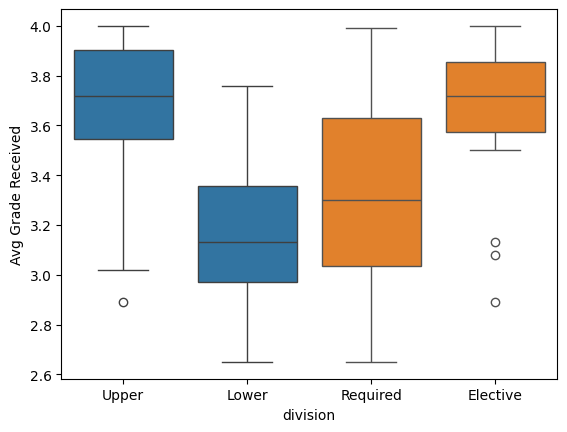

In [17]:
sns.boxplot(data=dsc_sets, x="division", y="Avg Grade Received")
sns.boxplot(data=dsc_sets, x="is_elective", y="Avg Grade Received")

<Axes: xlabel='division', ylabel='Avg Hours Worked'>

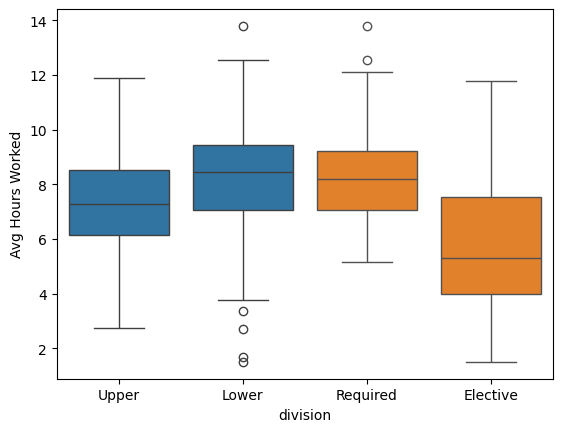

In [18]:
sns.boxplot(data=dsc_sets, x="division", y="Avg Hours Worked")
sns.boxplot(data=dsc_sets, x="is_elective", y="Avg Hours Worked")


In [31]:
model = ols("Learning_Average ~ C(division) * C(is_elective)", data=dsc_sets).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(division),0.725219,1.0,7.980119,0.005406
C(is_elective),0.918282,1.0,10.104538,0.001813
C(division):C(is_elective),0.012054,1.0,0.132639,0.716250
Residual,12.995581,143.0,NaN,NaN
